## Personality Trait Prediction

In [1]:
# !pip install nltk
# !pip install spacy
# !pip install pandas
# !pip install tensorflow
# !pip install scikit-learn
# !pip install openpyxl
# !python -m spacy download en_core_web_sm

In [2]:
import glob
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("words")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to C:\Users\Imran
[nltk_data]     Abbas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Imran
[nltk_data]     Abbas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Imran
[nltk_data]     Abbas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Data Preprocessing

In [3]:
survey = pd.read_csv("../Archive/Survey (45).csv")
survey = survey[~survey["Patient ID#"].isnull()]
survey = survey.iloc[:,[1]+list(range(6,173))].reset_index(drop=True)
survey["Patient ID#"] = survey["Patient ID#"].str.replace(',', '').astype("int64")
survey = survey.select_dtypes(include=['number'])

dataframe = pd.DataFrame()
for file in glob.glob(r"..\Archive\two_speakers_ID\*.csv"):
    dataframe = pd.concat([dataframe, pd.read_csv(file)])

dataframe = dataframe[dataframe["Role"] == "Patient"]
dataframe["ID"] = dataframe["ID"].astype("int64")
dataframe = (
    dataframe.groupby("ID")["Message"].apply(lambda msgs: " ".join(msgs)).reset_index()
    
)

merged = pd.merge(survey, dataframe, left_on="Patient ID#", right_on="ID")
merged = merged.drop(["Patient ID#"], axis=1)
merged.to_excel("../combined_hvp_numeric.xlsx", index=False)

In [4]:
df = merged.copy(deep=True)

In [5]:
df.columns

Index(['AI% 1', 'AI% 2', 'BQa1', 'BQa2', 'BQr1', 'BQr2', 'CQ1', 'VQ Total +',
       'VQ Total -', 'SQ Total +',
       ...
       'DIM-I- 1 Transposition', 'DIM-I- 2 Transposition',
       'DIM-S+ 1 Transposition', 'DIM-S+ 2 Transposition',
       'DIM-S- 1 Transposition', 'DIM-S- 2 Transposition', 'Rho 1', 'Rho 2',
       'ID', 'Message'],
      dtype='object', length=114)

In [5]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.multioutput import MultiOutputRegressor

# # Text and target variables
# X = df['Message']
# y = df.drop(columns=['ID','Message'])

# vectorizer = TfidfVectorizer()
# X_vectorized = vectorizer.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# model = MultiOutputRegressor(RandomForestRegressor())
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming df is already defined and contains your data
X = df['Message']
y = df.drop(columns=['ID', 'Message'])

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=100)  # Pad sequences to a fixed length

# Scaling the target variables
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=0.2, random_state=42)

# Defining the model
input_layer = Input(shape=(100,))  
embedding_layer = Embedding(input_dim=10000, output_dim=128)(input_layer)  
hidden_layer = LSTM(64, return_sequences=False)(embedding_layer)

# Output layer for 112 outputs
output = Dense(112, activation='linear')(hidden_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mse'])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 112)            │         7,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,688 (5.10 MB)

 Trainable params: 1,336,688 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.2087 - mse: 0.2087 - val_loss: 0.1893 - val_mse: 0.1893
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1731 - mse: 0.1731 - val_loss: 0.1163 - val_mse: 0.1163
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1017 - mse: 0.1017 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0645 - mse: 0.0645 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.04

In [12]:
# Predictions
predictions = model.predict(X_test)

# Rescale predictions if you want to interpret them in the original scale
predictions_rescaled = [scaler.inverse_transform([pred]) for pred in predictions]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [24]:
len(predictions_rescaled[0][0])

112

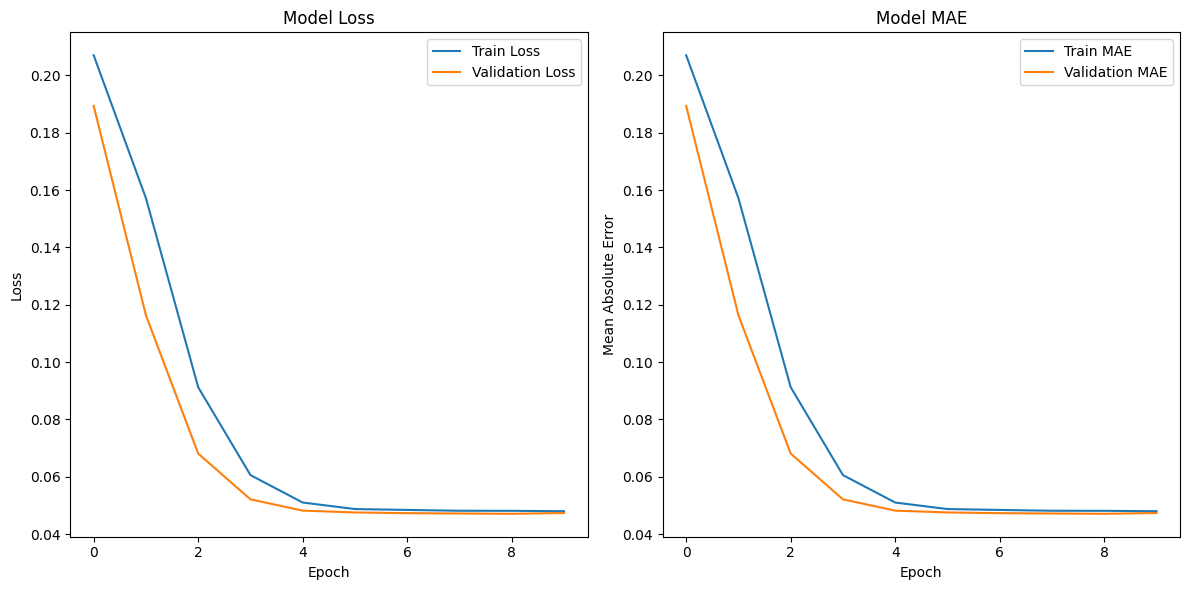

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train MAE')
plt.plot(history.history['val_mse'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
merged.head(1)['Message'][0]

"I can morning. i'm Okay, how are you. that's amazing i'm really happy for you. Oh yeah oh that's really nice. The weather and everything. I mean I, how can I ask for anything nicer. i'm not good not good at all. So i'm. My new therapist suggested that I get on medication or I talk to you about medication for. My Depression and anxiety. cymbalta helps with my anxiety a bit didn't really do anything for my depression and I was taking wellbutrin. For a very long time, I think. And it did work for a while. i've tried lexapro I didn't really like it because I sort of. I don't remember. The six months that I was on it, I just I guess was a robot during that time, but. I don't i'm not. opposed to it, those are just the ones that i've experienced and taken in terms of antidepressants and anti anxiety. i'm having anxiety attacks that last. More than. about an hour hour and a half and. A half have a I have an apple watch that tracks my heartbeat so my heartbeat will be around 121 30 for about a

In [19]:
# Evaluate the model
# last Test Loss: 161.1284637451172, Test MAE: 5.265908241271973


loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MSE: {mae}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0440 - mse: 0.0440
Test Loss: 0.04397791996598244, Test MSE: 0.04397791996598244


In [12]:
# Predict on test data
predictions = model.predict([, ])


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [25]:
merged.head(1)['Message'][0]

"I can morning. i'm Okay, how are you. that's amazing i'm really happy for you. Oh yeah oh that's really nice. The weather and everything. I mean I, how can I ask for anything nicer. i'm not good not good at all. So i'm. My new therapist suggested that I get on medication or I talk to you about medication for. My Depression and anxiety. cymbalta helps with my anxiety a bit didn't really do anything for my depression and I was taking wellbutrin. For a very long time, I think. And it did work for a while. i've tried lexapro I didn't really like it because I sort of. I don't remember. The six months that I was on it, I just I guess was a robot during that time, but. I don't i'm not. opposed to it, those are just the ones that i've experienced and taken in terms of antidepressants and anti anxiety. i'm having anxiety attacks that last. More than. about an hour hour and a half and. A half have a I have an apple watch that tracks my heartbeat so my heartbeat will be around 121 30 for about a

In [42]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# Assuming 'tokenizer' and 'scaler' have already been defined and fitted
# Also assuming 'model' is already trained and ready for predictions

# Input text for prediction
input_text = merged.head(1)['Message'][0]

# Convert the input text to sequences
input_sequence = tokenizer.texts_to_sequences([input_text])

# Pad the sequences to ensure consistent input shape
input_padded = pad_sequences(input_sequence, maxlen=100)  # Adjust maxlen as needed

# Reshape the input to have a single sample
input_padded = input_padded.reshape(1, 100)  # Ensures shape is (1, 100)

# Make predictions
predictions = model.predict(input_padded)

# Rescale the predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)  # No need for list comprehension

predictions_rescaled[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([ 5.8829296e-01,  7.0078969e-01,  1.0552574e+02,  5.1600052e+01,
        3.8974407e+00,  7.1367230e+00,  4.5893585e+02,  1.2115581e+01,
        2.1707865e+01,  1.5646606e+01,  6.4501434e+01,  7.2332706e+00,
       -3.6645043e-01, -3.1083024e-01, -7.6723778e-01, -1.9355035e-01,
        1.3160062e-01, -1.4179355e-01,  2.2134604e+00,  1.0447675e+00,
        3.2798610e+00,  1.4625472e+01,  3.8171818e+00,  3.8311708e+00,
        3.1550112e+00,  9.5492134e+00, -1.1704320e+00, -4.6643519e+00,
       -3.7381268e-01, -1.0430131e+01, -1.7663598e-02, -4.2871504e+00,
        1.9081200e+01,  3.0803247e+01,  7.8898132e+01,  4.5687988e+01,
        1.0492861e+01,  2.1305466e+01,  3.4778076e+01,  2.9275763e+01,
        1.0539068e+01, -7.9138458e-01, -3.2403746e+00,  7.5271618e-01,
        2.6235338e+01, -6.5515203e+00, -5.7303014e+00,  7.4908084e-01,
        2.8382545e+00,  6.6160450e+00,  6.6048403e+00,  1.8849756e+01,
        9.0920238e+00, -1.7623147e+00, -1.1315422e+00,  7.3676157e-01,
      

In [40]:
merged.head(1).values

array([[0.5, 0.864583333, 151, 90, 6.9, 13.9, 1042, 13, 13, 13, 83, 4,
        0.5, -0.64, -1.0, -0.78, 0.73, -0.58, 1, 0, 1, 33, 5, 4, 3, 6, 0,
        1, 0, -27, 0, -3, 83, 26, 96, 27, 7, 90, 27, 94, 6, 2, -2, 0.5,
        22, -6, 0, 0.636363636, 3, 8, 3, 14, 9, -5, 0, 0.777777778, 62,
        -29, -33, 1.0, 2, 0, 7, 62, 11, 3, 2, 0.727272727, 12, 0, -2,
        0.583333333, 8, 5, 3, 7, 0, 10, 13, 33, 7, 31, 6, 32, 5, 67, 19,
        70, 0, 12, 3, 50, 2, 5, 1, 7, 3, 7, 2, 1, 0, 7, 1, 0, 6, 29, 3,
        1, 0, 1, 0.934, 0.133, 12373,
        "I can morning. i'm Okay, how are you. that's amazing i'm really happy for you. Oh yeah oh that's really nice. The weather and everything. I mean I, how can I ask for anything nicer. i'm not good not good at all. So i'm. My new therapist suggested that I get on medication or I talk to you about medication for. My Depression and anxiety. cymbalta helps with my anxiety a bit didn't really do anything for my depression and I was taking wellbutrin. F

In [41]:
np.array([0.5, 0.864583333, 151, 90, 6.9, 13.9, 1042, 13, 13, 13, 83, 4,
        0.5, -0.64, -1.0, -0.78, 0.73, -0.58, 1, 0, 1, 33, 5, 4, 3, 6, 0,
        1, 0, -27, 0, -3, 83, 26, 96, 27, 7, 90, 27, 94, 6, 2, -2, 0.5,
        22, -6, 0, 0.636363636, 3, 8, 3, 14, 9, -5, 0, 0.777777778, 62,
        -29, -33, 1.0, 2, 0, 7, 62, 11, 3, 2, 0.727272727, 12, 0, -2,
        0.583333333, 8, 5, 3, 7, 0, 10, 13, 33, 7, 31, 6, 32, 5, 67, 19,
        70, 0, 12, 3, 50, 2, 5, 1, 7, 3, 7, 2, 1, 0, 7, 1, 0, 6, 29, 3,
        1, 0, 1, 0.934, 0.133, 12373]).mean()

131.7671356708584

# Old code

## Loading Embeddings

In [13]:
dataset = pd.read_excel("../combined.xlsx")

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Conservation        658 non-null    float64
 1   Conformity          112 non-null    float64
 2   Tradition           112 non-null    float64
 3   Security            112 non-null    float64
 4   Self-Transcendance  658 non-null    float64
 5   Benevolence         112 non-null    float64
 6   Universalism        112 non-null    float64
 7   Self-Enhancement    658 non-null    float64
 8   Power               112 non-null    float64
 9   Achievement         112 non-null    float64
 10  Stimulation         112 non-null    float64
 11  Openness to Change  658 non-null    float64
 12  Hedonism            112 non-null    float64
 13  Self-Direction      112 non-null    float64
 14  ID                  658 non-null    int64  
 15  Message             658 non-null    object 
dtypes: float

In [15]:
dataset = dataset[~dataset["Conformity"].isnull()]

In [16]:
dataset.columns

Index(['Conservation', 'Conformity', 'Tradition', 'Security',
       'Self-Transcendance', 'Benevolence', 'Universalism', 'Self-Enhancement',
       'Power', 'Achievement', 'Stimulation', 'Openness to Change', 'Hedonism',
       'Self-Direction', 'ID', 'Message'],
      dtype='object')

In [7]:
# pip install nltk spacy
# python -m spacy download en_core_web_sm

In [17]:
def process_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return list(set(lemmatized_tokens))

In [18]:
bag_of_words = []
for message in dataset["Message"]:
    bag_of_words += process_text(message)

In [19]:
bag_of_words = list(set(bag_of_words))

In [20]:
len(bag_of_words)

6801

In [21]:
X = []
y = []

for index, row in dataset.iterrows():

    encoding_vector = [0] * len(bag_of_words)

    for token in process_text(row["Message"]):

        if token in bag_of_words:

            index = bag_of_words.index(token)

            encoding_vector[index] += 1

    X.append(encoding_vector)

    y.append(
        list(
            row[
                [
                    "Conservation",
                    "Conformity",
                    "Tradition",
                    "Security",
                    "Self-Transcendance",
                    "Benevolence",
                    "Universalism",
                    "Self-Enhancement",
                    "Power",
                    "Achievement",
                    "Stimulation",
                    "Openness to Change",
                    "Hedonism",
                    "Self-Direction",
                ]
            ]
        )
    )

In [22]:
X = np.array(X)

In [23]:
y = np.array(y)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# X_train.shape

In [17]:
# y_train.shape

In [24]:
model = Sequential(
    [   Dense(1024, input_dim=X.shape[1], activation="relu", kernel_regularizer=l2(0.001)),  # Input layer
        Dropout(0.5),  # Dropout for regularization
        Dense(512, activation="relu"),  # Hidden layer
        Dense(y.shape[1], activation="linear"),  # Output layer (14 targets)
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mse"])

d:\projects\personality-trait\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
history = model.fit(X, y, epochs=500, batch_size=32, verbose=1)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 29.7245 - mse: 28.0438
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 13.0597 - mse: 11.7294
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 10.9017 - mse: 9.7600
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 7.3606 - mse: 6.3231
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 6.0649 - mse: 5.0825
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 4.9677 - mse: 4.0126
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 3.7421 - mse: 2.7958
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 3.3493 - mse: 2.4039
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 3.3114 - mse: 2.3665
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 2.8671 - mse: 1.9222
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 2.5388 - mse: 1.5959
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 2.4608 - mse: 1.5224
Epoch 13/500
4/4 ━━━━━━━━━━━━━━━

### [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 6.333333333, 5.0, 6.0]

In [26]:
list(
    dataset[
        [
            "Conservation",
            "Conformity",
            "Tradition",
            "Security",
            "Self-Transcendance",
            "Benevolence",
            "Universalism",
            "Self-Enhancement",
            "Power",
            "Achievement",
            "Stimulation",
            "Openness to Change",
            "Hedonism",
            "Self-Direction",
        ]
    ].values[3]
)

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 6.333333333, 5.0, 6.0]

In [24]:
import math

In [27]:
model.save("../svs.keras")

### Load and Use

In [28]:
model = tf.keras.models.load_model('../svs.keras')

In [30]:
testdata = pd.read_excel("../combined.xlsx")

In [28]:
testdata = testdata[~testdata["Conformity"].isnull()]

In [31]:
final_rows = []
columns = list(testdata.columns) + [
    f"predicted_{col}"
    for col in [
        "Conservation",
        "Conformity",
        "Tradition",
        "Security",
        "Self-Transcendance",
        "Benevolence",
        "Universalism",
        "Self-Enhancement",
        "Power",
        "Achievement",
        "Stimulation",
        "Openness to Change",
        "Hedonism",
        "Self-Direction",
    ]
    if col not in ["Messages", "ID"]
]

In [32]:
for index, row in testdata.iterrows():
    input_vector = [0] * len(bag_of_words)
    for token in process_text(row["Message"]):
        if token in bag_of_words:
            index = bag_of_words.index(token)
            input_vector[index] += 1

    output_vector = model.predict(np.array([input_vector]))[0]
    final_rows.append(list(row) + list(output_vector))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━

In [33]:
pd.DataFrame(final_rows, columns=columns).to_excel("../review.xlsx", index=False)

### Implementation on unseen data

In [34]:
unseen = pd.DataFrame()
for folder in glob.glob('../CEO_sample_transcripts/*'):
    for file in glob.glob(f"{folder}/*.csv"):
        unseen = pd.concat([unseen,pd.read_csv(file)])

In [35]:
unseen = unseen[~unseen["Detected Speaker"].str.contains("Reporter")]
unseen = unseen[~unseen["Detected Speaker"].str.contains("Speaker")]

In [36]:
unseen["Detected Speaker"].unique()

array(['Charles Janac', 'Chirag Patel', 'Christopher Richard Anzalone',
       'Chris Urmson', 'Clive T. Johnson', 'Dale Schwartz',
       'Damian Scokin', 'Daniel Houston', 'Daniel Mamadou',
       'Daniel P Mcgahn', 'Daniel Shachar', 'Darren Rebelez',
       'David Bruton Smith', 'David_Jin', 'David Jin'], dtype=object)

In [37]:
unseen = unseen.drop(columns=["Speaker"])

In [38]:
unseen_joined = unseen.groupby('Detected Speaker')['Text'].apply(' '.join).reset_index()

In [39]:
unseen_joined.to_excel("dataset_unseen.xlsx",index=False)

In [41]:
model = tf.keras.models.load_model('../svs.keras')

In [43]:
output = []
columns = list(unseen_joined.columns) + [
    f"predicted_{col}"
    for col in [
        "Conservation",
        "Conformity",
        "Tradition",
        "Security",
        "Self-Transcendance",
        "Benevolence",
        "Universalism",
        "Self-Enhancement",
        "Power",
        "Achievement",
        "Stimulation",
        "Openness to Change",
        "Hedonism",
        "Self-Direction",
    ]
]

In [44]:
for index, row in unseen_joined.iterrows():
    input_vector = [0] * len(bag_of_words)
    for token in process_text(row["Text"]):
        if token in bag_of_words:
            index = bag_of_words.index(token)
            input_vector[index] += 1

    output_vector = model.predict(np.array([input_vector]))[0]
    output.append(list(row) + list(output_vector))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [45]:
pd.DataFrame(output,columns=columns).to_excel("../ceo_transcripts_output.xlsx",index=False)